<a href="https://colab.research.google.com/github/EAterminator/clip-project/blob/main/Clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install open_clip_torch
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00


trainset size 50000
testset size 10000
torch.Size([32, 3, 224, 224])
tensor([0, 9, 6, 9, 2, 5, 4, 6, 0, 6, 5, 0, 1, 3, 4, 7, 8, 7, 2, 8, 5, 7, 9, 7,
        0, 3, 4, 2, 7, 0, 3, 7])


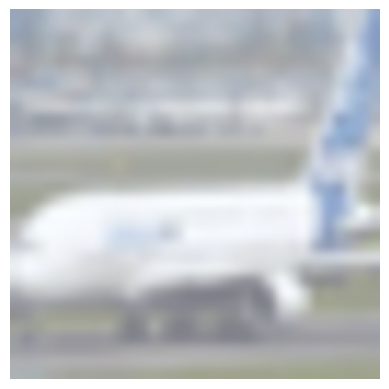

In [4]:
import torch
from PIL import Image
import open_clip
from urllib.request import urlopen
import io
import torchvision
import matplotlib.pyplot as plt
# load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

# load dataset


cifar10_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess) # use the preprocess for open_clip
cifar10_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
print("trainset size", len(cifar10_train_dataset))
print("testset size", len(cifar10_test_dataset))
trainloader = torch.utils.data.DataLoader(cifar10_train_dataset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=32, shuffle=False)

org_text = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
text = tokenizer(org_text)

# check the data
for images, labels in trainloader:
    print(images.shape)
    print(labels)
    # display an image
    image = images[0]
    # first do normalization as it was preprocessed with clip preprocess
    image = (image-image.min())/(image.max()-image.min())
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = (image + 1) / 2
    image = (image * 255).astype('uint8')
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    break


Perform Zero-shot Classification

In [ ]:
# perform zero-shot classification evaluation
correct = 0
tot = 0

for images, labels in testloader:
  with torch.no_grad(), torch.autocast(device):
      image_features = model.encode_image(images)
      text_features = model.encode_text(text)
      print(image_features.shape)
      image_features /= image_features.norm(dim=-1, keepdim=True) # (B, 512)
      text_features /= text_features.norm(dim=-1, keepdim=True)

      text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
      # print(labels)
      # print(torch.argmax(text_probs, dim=-1))
      correct += (torch.argmax(text_probs, dim=-1) == labels).sum().item()
      tot += len(labels)

print("Zero-shot Accuracy:", correct/tot)

Perform Linear Probing

In [ ]:
# first extract the embeddings and save it to a pt file
all_features = []

for images, labels in trainloader:
  with torch.no_grad(), torch.autocast(device):
    image_features = model.encode_image(images) # (B, 512)
    all_features.append(image_features)
# concatnate all features
all_features_tensor = torch.cat(all_features, dim=0) # (50000, 512)
# save the features to a pt file and save the file to the drive
from google.colab import drive
drive.mount('/content/drive')  # run once
save_path = '/content/drive/MyDrive/all_features.pt'
torch.save(all_features_tensor, save_path)
print("saved to:", save_path)

In [ ]:
# define a linear probe of mapping 512 to 10
probe = torch.nn.Linear(512, 10)
probe.to(device)

TODO: Complete the training part and eval part